In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CODING/project2/combine_data_since_2000_PROCESSED_2018-04-26.csv')
df.head()

,Player,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,Pfr_ID,AV,Team,Round,Pick
0,John Abraham,OLB,76,252,4.55,NaN,NaN,NaN,NaN,NaN,2000,AbraJo00,26.0,New York Jets,1.0,13.0
1,Shaun Alexander,RB,72,218,4.58,NaN,NaN,NaN,NaN,NaN,2000,AlexSh00,26.0,Seattle Seahawks,1.0,19.0
2,Darnell Alford,OT,76,334,5.56,25.0,23.0,94.0,8.48,4.98,2000,AlfoDa20,0.0,Kansas City Chiefs,6.0,188.0
3,Kyle Allamon,TE,74,253,4.97,29.0,NaN,104.0,7.29,4.49,2000,NaN,0.0,NaN,NaN,NaN
4,Rashard Anderson,CB,74,206,4.55,34.0,NaN,123.0,7.18,4.15,2000,AndeRa21,6.0,Carolina Panthers,1.0,23.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6218 entries, 0 to 6217
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Player     6218 non-null   object 
 1   Pos        6218 non-null   object 
 2   Ht         6218 non-null   int64  
 3   Wt         6218 non-null   int64  
 4   Forty      6046 non-null   float64
 5   Vertical   4796 non-null   float64
 6   BenchReps  4212 non-null   float64
 7   BroadJump  4754 non-null   float64
 8   Cone       3993 non-null   float64
 9   Shuttle    4063 non-null   float64
 10  Year       6218 non-null   int64  
 11  Pfr_ID     4895 non-null   object 
 12  AV         6218 non-null   float64
 13  Team       3738 non-null   object 
 14  Round      3738 non-null   float64
 15  Pick       3738 non-null   float64
dtypes: float64(9), int64(3), object(4)
memory usage: 777.4+ KB


### Questions and anwsers about data

1) Source of data
<br>
https://www.kaggle.com/savvastj/nfl-combine-data
<br><br>
2) Brief description of data
<br>
The data is nfl combine data of how athletes performed and where they got drafted
<br><br>
3) What is the target?
<br>
the target will be the round the player got drafted
<br><br>
4) Is this a classification or regression problem?
<br>
Technically its a classification problem but I am going to use regression to get close to the round drafted.
<br><br>
5) How many features?
<br>
11 features after i drop some of the things that are not needed like team and pfr_id
<br><br>
6) How many rows of data.
<br>
6218
<br><br>
7) What, if any, challenges do your foresee in cleaning, exploring, or modeling with this dataset?
<br>
just getting a model to perform well. Interesting cleaning process will have to really think about how to fill some values or drop.


###Data Cleaning

In [ ]:
#dropping unnecesarry rows
df.drop(columns=['Player','Pfr_ID','Team','Pick'],inplace=True)

In [ ]:
#check for Duplicates
df.duplicated().sum()

1

In [ ]:
#drop duplicates
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [ ]:
#missing data going to check each time after i fix to ensure it worked
df.isna().sum()

Pos             0
Ht              0
Wt              0
Forty         171
Vertical     1421
BenchReps    2005
BroadJump    1463
Cone         2224
Shuttle      2154
Year            0
AV              0
Round        2479
dtype: int64

In [ ]:
#drop missing forty times
df.dropna(subset=['Forty'],inplace=True)

In [ ]:
#missing data check
df.isna().sum()

Pos             0
Ht              0
Wt              0
Forty           0
Vertical     1295
BenchReps    1913
BroadJump    1334
Cone         2078
Shuttle      2009
Year            0
AV              0
Round        2358
dtype: int64

In [ ]:
#Fill in Round Undrafted players will be round 8 For classifying purposes
#First check value_counts to make sure No weird values
df['Round'].value_counts()

4.0    584
3.0    584
1.0    560
2.0    547
5.0    521
6.0    450
7.0    442
Name: Round, dtype: int64

In [ ]:
df['Round'].fillna(value=8,inplace=True)

In [ ]:
df['Round'].value_counts()

8.0    2358
4.0     584
3.0     584
1.0     560
2.0     547
5.0     521
6.0     450
7.0     442
Name: Round, dtype: int64

In [ ]:
#missing data check
df.isna().sum()

Pos             0
Ht              0
Wt              0
Forty           0
Vertical     1295
BenchReps    1913
BroadJump    1334
Cone         2078
Shuttle      2009
Year            0
AV              0
Round           0
dtype: int64

In [ ]:
df.describe()

,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,AV,Round
count,6046.00000,6046.000000,6046.000000,4751.000000,4133.000000,4712.000000,3968.000000,4037.000000,6046.000000,6046.000000,6046.000000
mean,73.79474,243.668707,4.783784,32.819406,20.958142,113.934423,7.283007,4.390647,2008.900265,5.196990,5.458981
std,2.62577,45.211492,0.305984,4.216011,6.407578,9.330584,0.423341,0.269369,5.379692,7.606366,2.539004
min,65.00000,149.000000,4.220000,17.500000,2.000000,74.000000,6.280000,3.730000,2000.000000,-4.000000,1.000000
25%,72.00000,206.000000,4.540000,30.000000,16.000000,108.000000,6.970000,4.190000,2004.000000,0.000000,3.000000
50%,74.00000,234.000000,4.700000,33.000000,21.000000,115.000000,7.190000,4.350000,2009.000000,1.000000,6.000000
75%,76.00000,281.750000,4.980000,35.500000,25.000000,121.000000,7.540000,4.560000,2014.000000,8.000000,8.000000
max,82.00000,375.000000,6.050000,46.000000,49.000000,147.000000,9.120000,5.560000,2018.000000,51.000000,8.000000


In [ ]:
#drop - av values which av is apporximate value
av = df['AV'] <0
df[av]


,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,AV,Round
1138,K,73,195,5.25,NaN,NaN,NaN,NaN,NaN,2003,-1.0,8.0
4087,QB,76,229,4.86,29.5,NaN,108.0,7.52,4.45,2012,-4.0,6.0
4931,K,73,236,5.17,NaN,14.0,NaN,NaN,NaN,2015,-2.0,8.0


In [ ]:
df.drop(index=[1138,4087,4931],inplace= True)

In [ ]:
#going to impute the rest of the values with mean by round drafted/undrafted with a function

In [ ]:
rounds = [1,2,3,4,5,6,7,8]
def fill_function(col):
  for r in rounds:
    round_filter = df['Round'] == r
    mean = df[round_filter][col].mean()
    df.loc[round_filter,col] = df.loc[round_filter,col].fillna(value=mean)


In [ ]:
fill_function('Vertical')
df.isna().sum()

Pos             0
Ht              0
Wt              0
Forty           0
Vertical        0
BenchReps    1911
BroadJump    1332
Cone         2076
Shuttle      2007
Year            0
AV              0
Round           0
dtype: int64

In [ ]:
fill_function('BenchReps')
df.isna().sum()

Pos             0
Ht              0
Wt              0
Forty           0
Vertical        0
BenchReps       0
BroadJump    1332
Cone         2076
Shuttle      2007
Year            0
AV              0
Round           0
dtype: int64

In [ ]:
fill_function('BroadJump')
df.isna().sum()

Pos             0
Ht              0
Wt              0
Forty           0
Vertical        0
BenchReps       0
BroadJump       0
Cone         2076
Shuttle      2007
Year            0
AV              0
Round           0
dtype: int64

In [ ]:
fill_function('Cone')
df.isna().sum()

Pos             0
Ht              0
Wt              0
Forty           0
Vertical        0
BenchReps       0
BroadJump       0
Cone            0
Shuttle      2007
Year            0
AV              0
Round           0
dtype: int64

In [ ]:
fill_function('Shuttle')
df.isna().sum()
#The reason i did it in seperate code block satisfying to see it fill !!!!

Pos          0
Ht           0
Wt           0
Forty        0
Vertical     0
BenchReps    0
BroadJump    0
Cone         0
Shuttle      0
Year         0
AV           0
Round        0
dtype: int64

#Value Counts for one object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6043 entries, 0 to 6217
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Pos        6043 non-null   object 
 1   Ht         6043 non-null   int64  
 2   Wt         6043 non-null   int64  
 3   Forty      6043 non-null   float64
 4   Vertical   6043 non-null   float64
 5   BenchReps  6043 non-null   float64
 6   BroadJump  6043 non-null   float64
 7   Cone       6043 non-null   float64
 8   Shuttle    6043 non-null   float64
 9   Year       6043 non-null   int64  
 10  AV         6043 non-null   float64
 11  Round      6043 non-null   float64
dtypes: float64(8), int64(3), object(1)
memory usage: 613.7+ KB


In [ ]:
df['Pos'].value_counts()

WR      842
CB      623
RB      531
DE      479
DT      453
OT      449
OLB     422
OG      365
QB      342
TE      326
ILB     265
FS      225
SS      207
C       166
FB      116
P        95
K        59
LS       20
S        20
EDGE     19
G        12
NT        3
LB        2
DB        1
OL        1
Name: Pos, dtype: int64

In [ ]:
#fix inconsistent naming

In [ ]:
df['Pos'].replace({'DB':'CB','LB':'ILB','NT':'DT','G':'OG','EDGE':'DE','S':'SS'},inplace=True)

In [ ]:
#undrafted player just going to drop
ol = df.loc[:,'Pos']=='OL'
df[ol]

,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,AV,Round
6070,OL,77,308,5.33,28.5,26.0,97.0,7.86,4.88,2018,0.0,8.0


In [ ]:
df.drop(index=6070,inplace=True)

In [ ]:
ol = df.loc[:,'Pos']=='OL'
df[ol]

,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,AV,Round


In [ ]:
df['Pos'].value_counts()

WR     842
CB     624
RB     531
DE     498
DT     456
OT     449
OLB    422
OG     377
QB     342
TE     326
ILB    267
SS     227
FS     225
C      166
FB     116
P       95
K       59
LS      20
Name: Pos, dtype: int64

#Exploring Data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


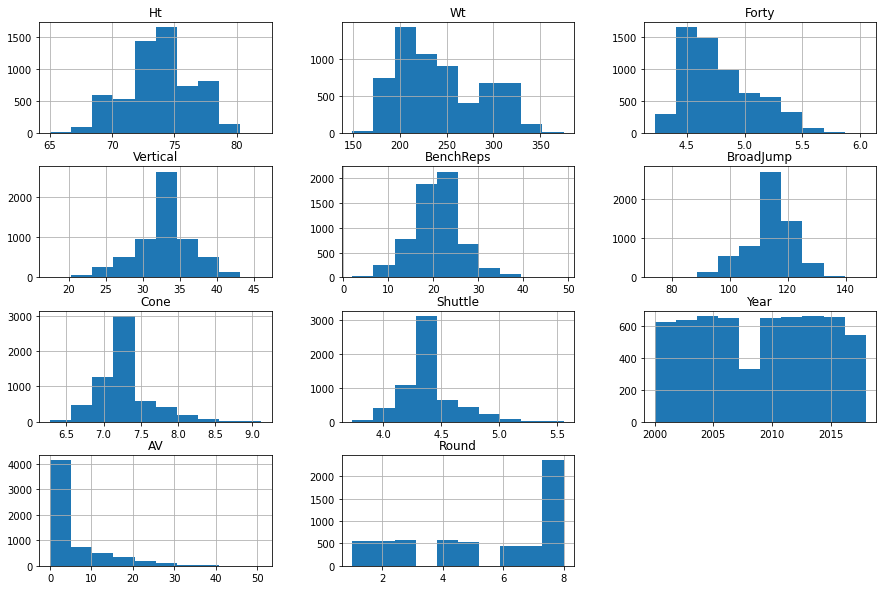

In [ ]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df.hist(ax = ax);
plt.savefig('hists.png')
#files.download('hists.png')
#Plot hists on the numeric rows

In [ ]:
df.columns

Index(['Pos', 'Ht', 'Wt', 'Forty', 'Vertical', 'BenchReps', 'BroadJump',
       'Cone', 'Shuttle', 'Year', 'AV', 'Round'],
      dtype='object')

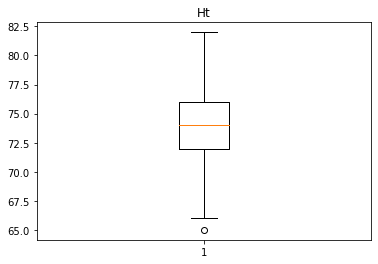

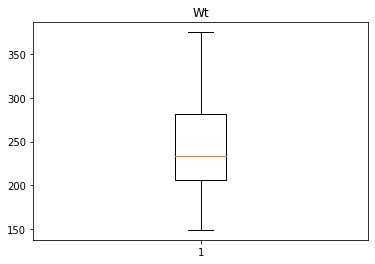

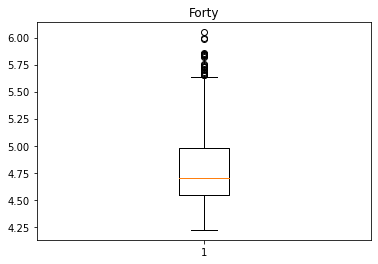

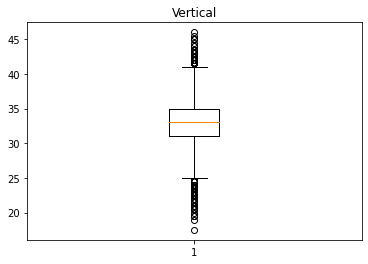

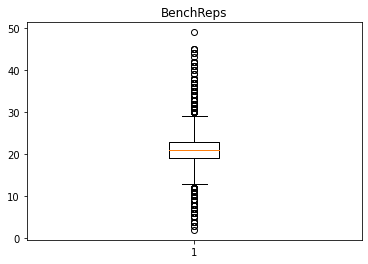

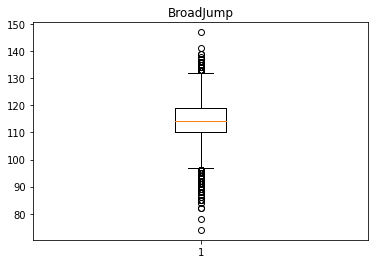

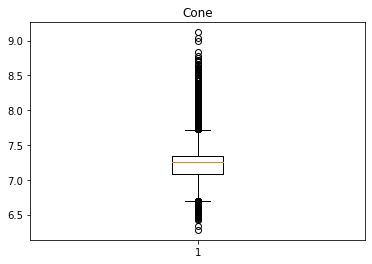

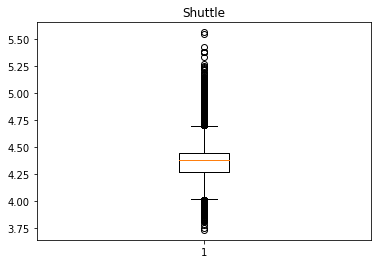

In [ ]:
#boxPlots On numeric columns besides year av or round
plt.boxplot(df['Ht']);
plt.title('Ht')
plt.show()
plt.boxplot(df['Wt']);
plt.title('Wt')
plt.show()
plt.boxplot(df['Forty']);
plt.title('Forty')
plt.show()
plt.boxplot(df['Vertical']);
plt.title('Vertical')
plt.show()
plt.boxplot(df['BenchReps']);
plt.title('BenchReps')
plt.show()
plt.boxplot(df['BroadJump']);
plt.title('BroadJump')
plt.show()
plt.boxplot(df['Cone']);
plt.title('Cone')
plt.show()
plt.boxplot(df['Shuttle']);
plt.title('Shuttle')
plt.show()

In [ ]:
#There are a few Outliers in 40 yard dash some slower times

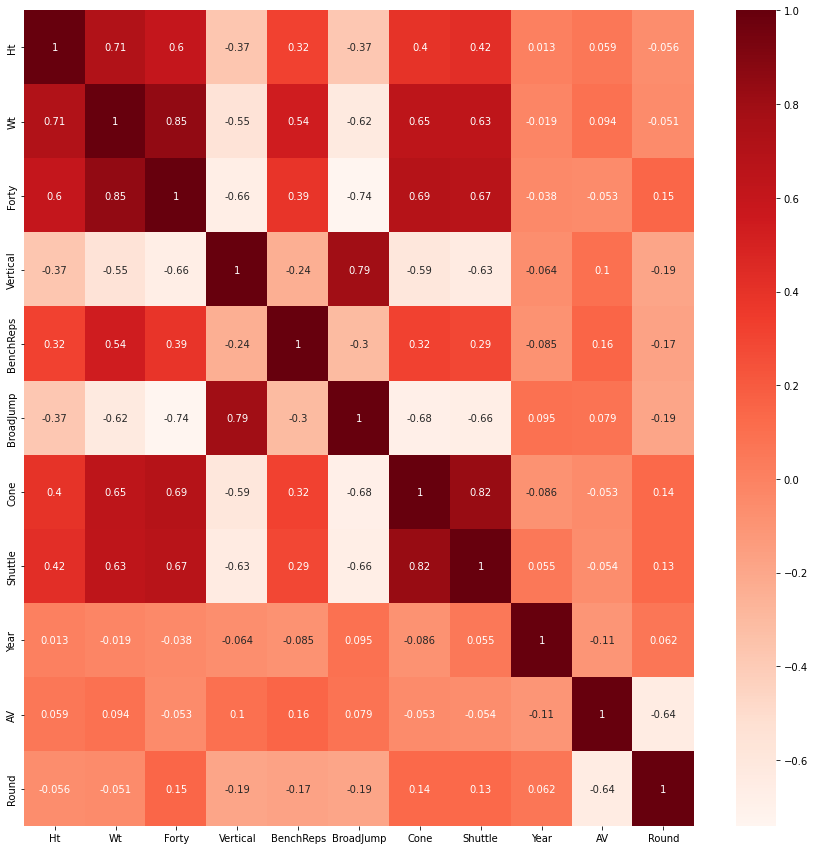

In [ ]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
sns.heatmap(df.corr(),cmap='Reds',annot=True, ax=ax)

In [ ]:
#Av is negatively correlated to my Target of Round
#Forty Postively COrrelated to ht and wt
#Cone and Shuttle Postively Correlated to Eachtoher and Ht Wt Forty

In [ ]:
av_mean_per_round = []
for r in rounds:
  round_filter = df['Round'] == r
  av_mean_per_round.append(df[round_filter]['AV'].mean())

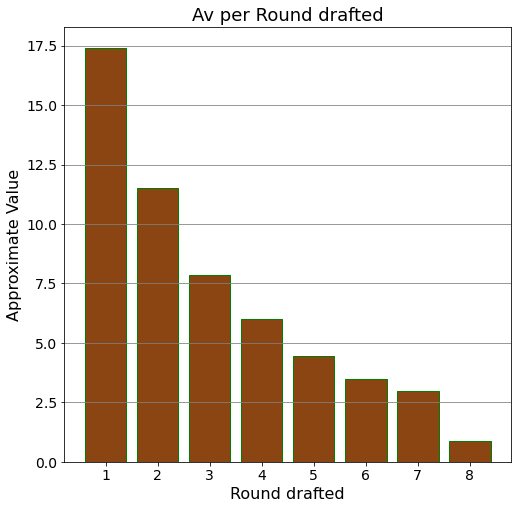

In [ ]:
plt.figure(figsize=(8,8))
plt.bar(rounds,av_mean_per_round,
         color='saddlebrown',
         edgecolor='green')
plt.grid(color='grey',axis='y')
plt.xlabel('Round drafted',fontsize=16)
plt.ylabel('Approximate Value',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Av per Round drafted', fontsize=18)
plt.savefig('avround.png')
#files.download('avround.png');

In [ ]:
def eval_model(true, pred):
  mse = mean_squared_error(true, pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(true, pred)

  print(f'MSE: {mse},\n RMSE: {rmse},\n R^2: {r2} ')

In [ ]:
#Train test split
X = df.drop(columns='Round')
y = df['Round']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
#pre processing
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

num_select = make_column_selector(dtype_include='number')
cat_select = make_column_selector(dtype_include='object')

col_trans = make_column_transformer((scaler, num_select), (ohe, cat_select), remainder='passthrough')

In [ ]:
#log reg pipe fit and metrics
lin_reg = LinearRegression()
lin_reg_pipe = make_pipeline(col_trans,lin_reg)
lin_reg_pipe.fit(X_train, y_train)

print('Train Evaluation')
eval_model(y_train, lin_reg_pipe.predict(X_train))

print('\nTest Evaluation')
eval_model(y_test, lin_reg_pipe.predict(X_test))

Train Evaluation
MSE: 3.3839862261729343,
 RMSE: 1.839561422234369,
 R^2: 0.4763234750423885 

Test Evaluation
MSE: 3.254822250414807,
 RMSE: 1.8041125936079507,
 R^2: 0.4905943881404847 


In [ ]:
lin_reg_pipe.get_params(deep=True);

In [ ]:
lin_params = {'linearregression__fit_intercept': [True,False] ,'linearregression__copy_X': [True,False],'linearregression__positive': [True,False]}
lin_grid = GridSearchCV(lin_reg_pipe, lin_params)
lin_grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f2a345d70d0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f2a345d71d0>)])),
                                       ('linearre

In [ ]:
print(lin_grid.best_params_)

{'linearregression__copy_X': True, 'linearregression__fit_intercept': False, 'linearregression__positive': False}


In [ ]:
#tuned logistic regression model metrics
lin_model = lin_grid.best_estimator_
print('Train Evaluation')
eval_model(y_train, lin_model.predict(X_train))

print('\nTest Evaluation')
eval_model(y_test, lin_model.predict(X_test))

Train Evaluation
MSE: 3.3839862261729343,
 RMSE: 1.839561422234369,
 R^2: 0.4763234750423885 

Test Evaluation
MSE: 3.254822250414807,
 RMSE: 1.8041125936079507,
 R^2: 0.4905943881404847 


In [ ]:
#lgbm pipe fit and metrics
lgbm = LGBMRegressor()

lgbm_pipe = make_pipeline(col_trans,lgbm)
lgbm_pipe.fit(X_train, y_train);

print('Train Evaluation')
eval_model(y_train, lgbm_pipe.predict(X_train))

print('\nTest Evaluation')
eval_model(y_test, lgbm_pipe.predict(X_test))

Train Evaluation
MSE: 0.7675394166033083,
 RMSE: 0.876093269351676,
 R^2: 0.8812222191254652 

Test Evaluation
MSE: 1.4641066308582762,
 RMSE: 1.2100027400209787,
 R^2: 0.7708556484075642 


In [ ]:
lgbm_pipe.get_params();

In [ ]:
lgbm_params = {'lgbmregressor__max_depth':[2,8,10,12,15,25],'lgbmregressor__n_estimators':[40,60,80,100,120,140],'lgbmregressor__num_leaves':[5,15,20,25,35]}
lgbm_grid = GridSearchCV(lgbm_pipe, lgbm_params)
lgbm_grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f2a345d70d0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f2a345d71d0>)])),
                                       ('lgbmregr

In [ ]:
print(lgbm_grid.best_params_)

{'lgbmregressor__max_depth': 12, 'lgbmregressor__n_estimators': 100, 'lgbmregressor__num_leaves': 25}


In [ ]:
#tuned lgbm model metrics
lgbm_model = lgbm_grid.best_estimator_
print('Train Evaluation')
eval_model(y_train, lgbm_model.predict(X_train))

print('\nTest Evaluation')
eval_model(y_test, lgbm_model.predict(X_test))

Train Evaluation
MSE: 0.8874996568866514,
 RMSE: 0.9420720019651637,
 R^2: 0.8626582068730551 

Test Evaluation
MSE: 1.4422412214175062,
 RMSE: 1.2009334791808854,
 R^2: 0.7742777591766898 


In [ ]:
#random forest pipe fit and metrics
ran_for = RandomForestRegressor()
ran_for_pipe = make_pipeline(col_trans,ran_for)
ran_for_pipe.fit(X_train, y_train)

print('Train Evaluation')
eval_model(y_train, ran_for_pipe.predict(X_train))

print('\nTest Evaluation')
eval_model(y_test, ran_for_pipe.predict(X_test))

Train Evaluation
MSE: 0.24292564555285806,
 RMSE: 0.49287487819208037,
 R^2: 0.9624069220783809 

Test Evaluation
MSE: 1.5301069490403705,
 RMSE: 1.2369749185170937,
 R^2: 0.7605260728179333 


In [ ]:
ran_for_pipe.get_params();

In [ ]:
forest_params = {'randomforestregressor__min_samples_split': [2,4],'randomforestregressor__n_estimators':[100,200,300],'randomforestregressor__max_depth':[6,8,10,12]}
forest_grid = GridSearchCV(ran_for_pipe, forest_params)
forest_grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f2a345d70d0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f2a345d71d0>)])),
                                       ('randomfo

In [ ]:
print(forest_grid.best_params_)

{'randomforestregressor__max_depth': 12, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 300}


In [ ]:
#tuned random forest model and metrics
forest_model = forest_grid.best_estimator_

print('Train Evaluation')
eval_model(y_train, forest_model.predict(X_train))

print('\nTest Evaluation')
eval_model(y_test, forest_model.predict(X_test))

Train Evaluation
MSE: 0.4518330656683216,
 RMSE: 0.6721852911722493,
 R^2: 0.9300782113532046 

Test Evaluation
MSE: 1.5167558535664527,
 RMSE: 1.2315664227180168,
 R^2: 0.7626156256216291 


I would choose the  lgbm model for production has the similar results as the random forest but less overfit.
<br> and the linear regression model has poor accuracy numbers compared to the other two
